# Song Generation: Neural Style Transfer for audio

With the use of convolutional neural networks (CNNs), we saw a vast rise in works involving style transfer to create a new image involving the content from one image and the style from a different image. In this project, we will be investigating applications and usage of CNNs in generating audios from random noise containing the content (i.e. tempo, melody) of one audio clip and the style of another audio (i.e. instrument types, pitch). The solution to this problem can potentially allow generation of new audio through the mixture of two completely different types of audio content.

### Import libraries

In [1]:
import sys
import numpy as np
import tensorflow as tf
import librosa
import os
from magenta.models.nsynth import utils
from magenta.models.nsynth.wavenet import fastgen
from IPython.display import Audio, display
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'jpg'

Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


### Load style and content

In [2]:
fname1 = 'bensound-ukulele_1s.mp3'
sr1 = 16000
audio1 = utils.load_audio(fname1, sample_length=64000, sr=sr1)
print audio1
sample_length1 = audio1.shape[0]
print('{} samples, {} seconds'.format(sample_length1, sample_length1 / float(sr1)))

[0. 0. 0. ... 0. 0. 0.]
16719 samples, 1.0449375 seconds


In [7]:
%time encoding1 = fastgen.encode(audio1, 'wavenet-ckpt/model.ckpt-200000', sample_length1)

INFO:tensorflow:Restoring parameters from wavenet-ckpt/model.ckpt-200000
CPU times: user 15.3 s, sys: 796 ms, total: 16.1 s
Wall time: 7.97 s


In [8]:
fname2 = 'fire_1s.mp3'
sr2 = 16000
audio2 = utils.load_audio(fname2, sample_length=64000, sr=sr2)
sample_length2 = audio2.shape[0]
print('{} samples, {} seconds'.format(sample_length2, sample_length2 / float(sr2)))

16704 samples, 1.044 seconds


In [10]:
%time encoding2 = fastgen.encode(audio2, 'wavenet-ckpt/model.ckpt-200000', sample_length2)

INFO:tensorflow:Restoring parameters from wavenet-ckpt/model.ckpt-200000
CPU times: user 15.1 s, sys: 737 ms, total: 15.8 s
Wall time: 7.86 s


In [25]:
def load_audio(path):
    display(Audio(path))

In [26]:
print "Content Audio:"
load_audio("bensound-ukulele_1s.mp3")
print "Style Audio:"
load_audio("fire_1s.mp3")

Content Audio:


Style Audio:


### Compute content and style feats

In [11]:
print(encoding1.shape)
print(encoding2.shape)

(1, 32, 16)
(1, 32, 16)


Text(0.5,1,'NSynth Encoding')

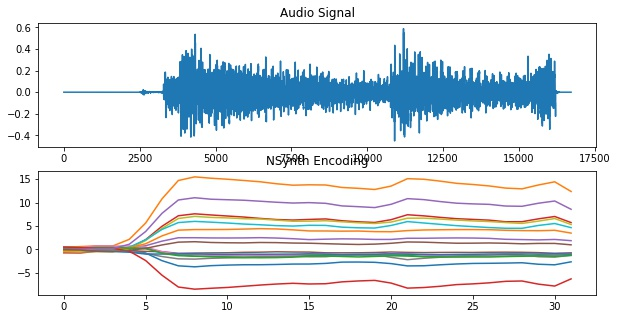

In [13]:
fig, axs = plt.subplots(2, 1, figsize=(10, 5))
axs[0].plot(audio1);
axs[0].set_title('Audio Signal')
axs[1].plot(encoding1[0]);
axs[1].set_title('NSynth Encoding')

Text(0.5,1,'NSynth Encoding')

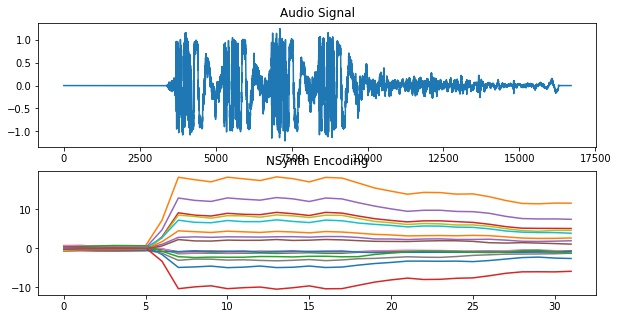

In [14]:
fig, axs = plt.subplots(2, 1, figsize=(10, 5))
axs[0].plot(audio2);
axs[0].set_title('Audio Signal')
axs[1].plot(encoding2[0]);
axs[1].set_title('NSynth Encoding')

In [20]:
print encoding2.shape
features = np.reshape(encoding2, (-1, encoding2.shape[1]))
print features.shape
style_gram = np.matmul(features.T, features)
print style_gram.shape

print style_gram

print features

(1, 32, 16)
(16, 32)
(32, 32)
[[  191.31091   -750.996       48.877453 ...   418.3008    -522.8987
    -90.587746]
 [ -750.996     2989.846     -190.57787  ... -1664.2804    2083.6145
    360.94403 ]
 [   48.877453  -190.57787     12.763655 ...   104.93826   -130.97874
    -22.750465]
 ...
 [  418.3008   -1664.2804     104.93826  ...   970.1737   -1213.623
   -210.71146 ]
 [ -522.8987    2083.6145    -130.97874  ... -1213.623     1518.621
    263.48227 ]
 [  -90.587746   360.94403    -22.750465 ...  -210.71146    263.48227
     45.97554 ]]
[[ 4.29277182e-01  7.03522861e-01  3.29924703e-01 -6.66038632e-01
   1.85480371e-01  8.28276128e-02  7.32400775e-01 -2.86384612e-01
  -5.57688296e-01 -1.07146107e-01 -1.98792666e-01 -2.39044338e-01
   2.86053658e-01  2.83636183e-01  1.16961248e-01 -2.28035972e-01
   3.29621553e-01  6.35456622e-01  2.85051256e-01 -5.81663787e-01
   1.02032892e-01 -1.96767971e-01  7.99966335e-01 -3.39843601e-01
  -4.17158633e-01 -8.54330808e-02 -4.39585239e-01 -3.45284

In [23]:
from sys import stderr

ALPHA= 0.005
BETA = 1e-2
learning_rate= 1e-3
iterations = 100
output_file_suffix = "out_"+ str(ALPHA)

    

result = None
interim_result = None
with tf.Graph().as_default():
    print ALPHA

    # Build graph with variable input
    print audio1.shape
    x = tf.Variable(np.random.randn(audio1.shape[0]).astype(np.float32)*1e-3, name="x")
    print "x shape",x.shape
    #print "x ",x
    print "encoding1 shape",encoding1.shape

    
    #opt = tf.train.AdamOptimizer(0.001)
    #opt = tf.train.AdamOptimizer(0.001).minimize(loss)
    #opt = tf.train.GradientDescentOptimizer(0.01).minimize(loss)

        
    # Optimization
    with tf.Session() as sess:
        
        
        sess.run(tf.global_variables_initializer())
        v = sess.run(x)
        print "x:::",v

        %time encoding2_gen = fastgen.encode(x.eval(), 'wavenet-ckpt/model.ckpt-200000', v.shape[0])
    
        print "x shape",x.shape
        print "encoding1 shape",encoding1.shape
        print "encoding_gen shape",encoding2_gen.shape

        content_loss = ALPHA * 2 * tf.nn.l2_loss(
                encoding2_gen - encoding1)


        features = np.reshape(encoding2_gen, (-1, encoding2.shape[1]))
        gram = np.matmul(features.T, features)

        style_loss =  2 * tf.nn.l2_loss(gram - style_gram)

         # Overall loss
        loss = content_loss + style_loss

    
        opt = tf.contrib.opt.ScipyOptimizerInterface(loss, method='L-BFGS-B', options={'maxiter': 150})
       
        print('Started optimization.')
        #opt.minimize(sess)
        
        
        opt.minimize(sess, feed_dict={x:x.eval()})
            #step_handler_callback(interim_result, i)
            
        #EPOCH_COUNT = 3000
        #for i in range(EPOCH_COUNT):
        #    # opt.minimize(sess)
        #    sess.run([opt, loss])
        #    if i>0 and i%50 ==0:
        #        print 'i:' , i , 'Interim loss:', loss.eval()
        #    if  i%300 ==0:
        #        interim_result = x.eval()
        #        step_handler_callback(interim_result, i)    
                
        result = x.eval()

0.005
(16719,)
x shape (16719,)
x  <tf.Variable 'x:0' shape=(16719,) dtype=float32_ref>
encoding1 shape (1, 32, 16)
x::: [ 0.00064217 -0.00019814  0.00088881 ...  0.00040907 -0.00211456
 -0.00069857]
INFO:tensorflow:Restoring parameters from wavenet-ckpt/model.ckpt-200000
CPU times: user 15.7 s, sys: 669 ms, total: 16.4 s
Wall time: 8.04 s
x shape (16719,)
encoding1 shape (1, 32, 16)
encoding_gen shape (1, 32, 16)
Started optimization.
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  Objective function value: 219387776.000000
  Number of iterations: 0
  Number of functions evaluations: 1


In [79]:
%time fastgen.synthesize(encoding2_gen, save_paths=['gen2_' + fname],checkpoint_path='wavenet-ckpt/model.ckpt-200000', samples_per_save=sample_length1)

INFO:tensorflow:Restoring parameters from wavenet-ckpt/model.ckpt-200000
INFO:tensorflow:Sample: 0
INFO:tensorflow:Saving: gen2_bensound-ukulele_3s.mp3
INFO:tensorflow:Sample: 100
INFO:tensorflow:Sample: 200
INFO:tensorflow:Sample: 300
INFO:tensorflow:Sample: 400
INFO:tensorflow:Sample: 500
INFO:tensorflow:Sample: 600
INFO:tensorflow:Sample: 700
INFO:tensorflow:Sample: 800
INFO:tensorflow:Sample: 900
INFO:tensorflow:Sample: 1000
INFO:tensorflow:Sample: 1100
INFO:tensorflow:Sample: 1200
INFO:tensorflow:Sample: 1300
INFO:tensorflow:Sample: 1400
INFO:tensorflow:Sample: 1500
INFO:tensorflow:Sample: 1600
INFO:tensorflow:Sample: 1700
INFO:tensorflow:Sample: 1800
INFO:tensorflow:Sample: 1900
INFO:tensorflow:Sample: 2000
INFO:tensorflow:Sample: 2100
INFO:tensorflow:Sample: 2200
INFO:tensorflow:Sample: 2300
INFO:tensorflow:Sample: 2400
INFO:tensorflow:Sample: 2500
INFO:tensorflow:Sample: 2600
INFO:tensorflow:Sample: 2700
INFO:tensorflow:Sample: 2800
INFO:tensorflow:Sample: 2900
INFO:tensorflow:

KeyboardInterrupt: 

In [28]:
print "Final Generated Audio:"
load_audio("gen2_bensound-ukulele_1s.mp3")

Final Generated Audio:


INFO:tensorflow:Restoring parameters from wavenet-ckpt/model.ckpt-200000


Text(0.5,1,'NSynth Encoding')

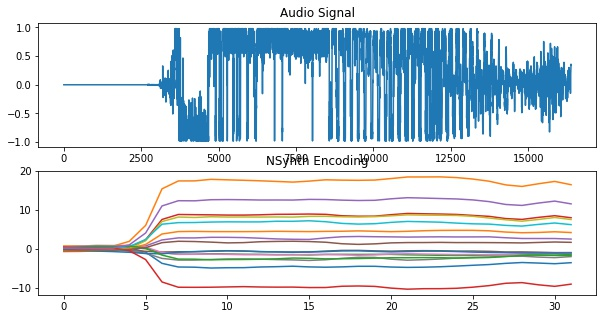

In [34]:
audio3 = utils.load_audio("gen2_bensound-ukulele_1s.mp3", sample_length=64000, sr=16000)
fig, axs = plt.subplots(2, 1, figsize=(10, 5))
axs[0].set_title('Audio Signal')
axs[0].plot(audio3);

axs[1].plot(encoding2_gen[0]);
axs[1].set_title('NSynth Encoding')

In [35]:
# Reads wav file and produces spectrum
def convert_audio_to_spectogram(filename):
    FFT_WINDOW_SIZE = 2048
    CLIP_SIZE = 340
    x, fs = librosa.load(filename)
    S = librosa.stft(x, FFT_WINDOW_SIZE)
    S = np.log1p(np.abs(S[:,:CLIP_SIZE]))  
    return S,fs

In [40]:
def plot_spectogram(images_list):
    Y_AXIS_TRIM = 100
    IMG_WIDTH = 20
    IMG_HEIGHT = 20

    plt.figure(figsize=(IMG_WIDTH, IMG_HEIGHT))

    for i in range(len(images_list)):
        plt.subplot(1, len(images_list), i+1)
        plt.title(images_list[i]["name"])
        plt.imshow(images_list[i]["data"][:Y_AXIS_TRIM,:])
    plt.show()

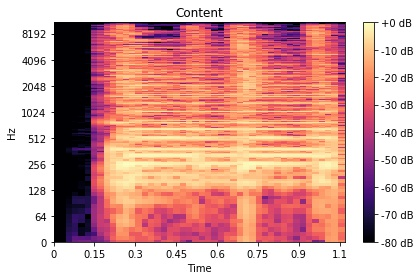

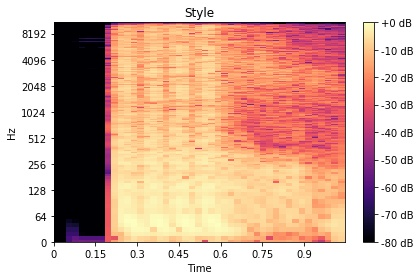

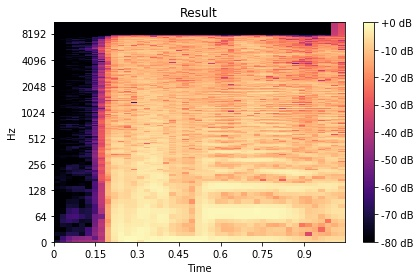

In [45]:
a_content,fs = convert_audio_to_spectogram('bensound-ukulele_1s.mp3')
a_style, fs = convert_audio_to_spectogram('fire_1s.mp3')
a_result, fs = convert_audio_to_spectogram('gen2_bensound-ukulele_1s.mp3')




import librosa.display
def plot_spectogram2(audio, title):
    librosa.display.specshow(librosa.amplitude_to_db(audio, ref=np.max), y_axis='log', x_axis='time')
    plt.title(title)
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()
    
plot_spectogram2(a_content,'Content')
plot_spectogram2(a_style,'Style')
plot_spectogram2(a_result,'Result')